In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# ckd: chronic kidney disease
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.sample(5).show()

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
37,60,1.025,0,0,normal,normal,notpresent,notpresent,111,35,0.8,135,4.1,16.2,50,5500,5.7,no,no,no,good,no,no,0
55,80,1.02,0,0,normal,normal,notpresent,notpresent,133,17,1.2,135,4.8,13.2,41,6800,5.3,no,no,no,good,no,no,0
49,100,1.01,3,0,abnormal,abnormal,notpresent,notpresent,129,158,11.8,122,3.2,8.1,24,9600,3.5,yes,yes,no,poor,yes,yes,1
22,60,1.025,0,0,normal,normal,notpresent,notpresent,97,18,1.2,138,4.3,13.5,42,7900,6.4,no,no,no,good,no,no,0
30,80,1.02,0,0,normal,normal,notpresent,notpresent,131,38,1,147,3.8,14.1,45,9400,5.3,no,no,no,good,no,no,0


In [3]:
ckd.group('Class')

Class,count
0,115
1,43


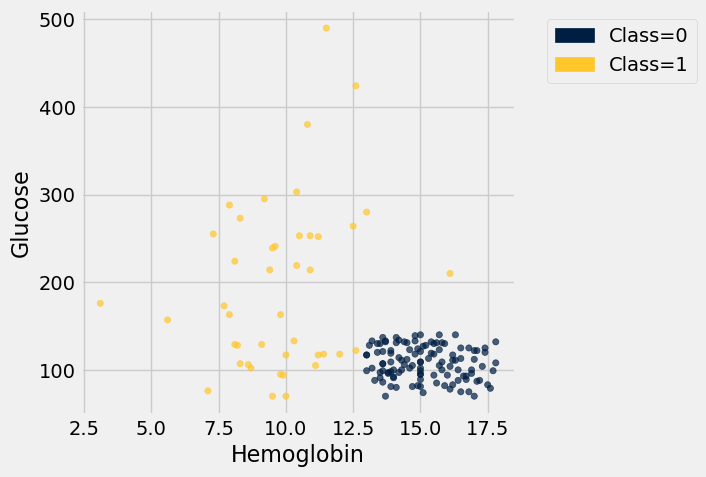

In [4]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

In [5]:
max_glucose_for_0 = ckd.where('Class',are.equal_to(0)).column('Glucose').max()
min_hemoglobin_for_0 = ckd.where('Class',are.equal_to(0)).column('Hemoglobin').min()

max_glucose_for_0, min_hemoglobin_for_0

(140, 13.0)

In [6]:
def classify_manually(hemoglobin, glucose):
    if hemoglobin < min_hemoglobin_for_0 or glucose > max_glucose_for_0:
        return 1
    else:
        return 0

In [7]:
classify_manually(15, 100)

0

In [8]:
classify_manually(10, 300)

1

In [9]:
banknotes = Table.read_table('data/banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


In [10]:
banknotes.group('Class')

Class,count
0,762
1,610


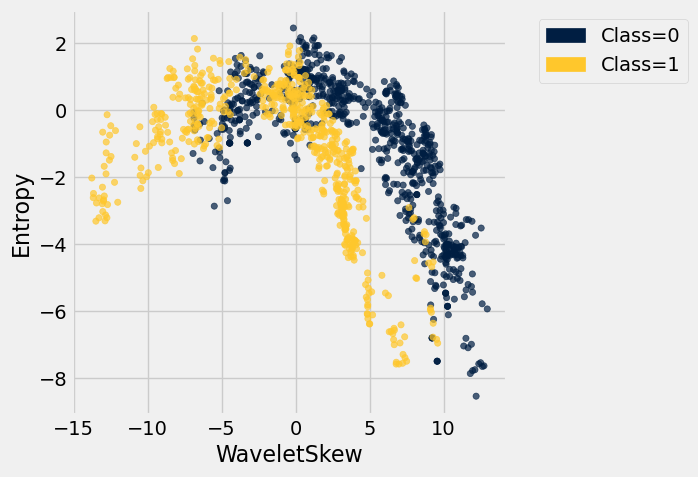

In [11]:
banknotes.scatter('WaveletSkew', 'Entropy', group='Class')

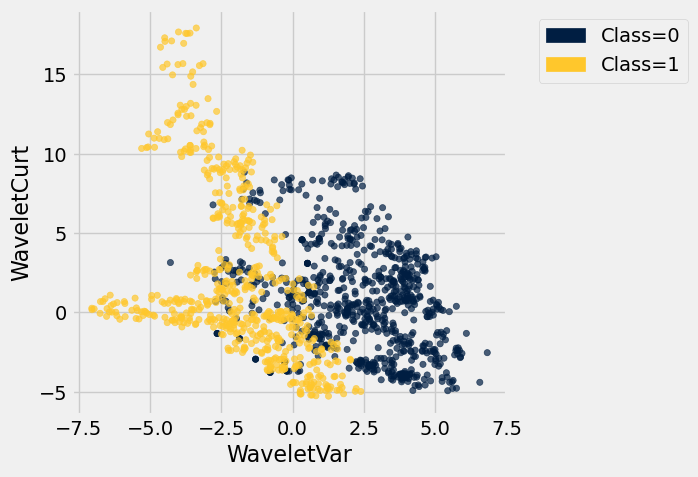

In [12]:
banknotes.scatter('WaveletVar', 'WaveletCurt', group='Class')

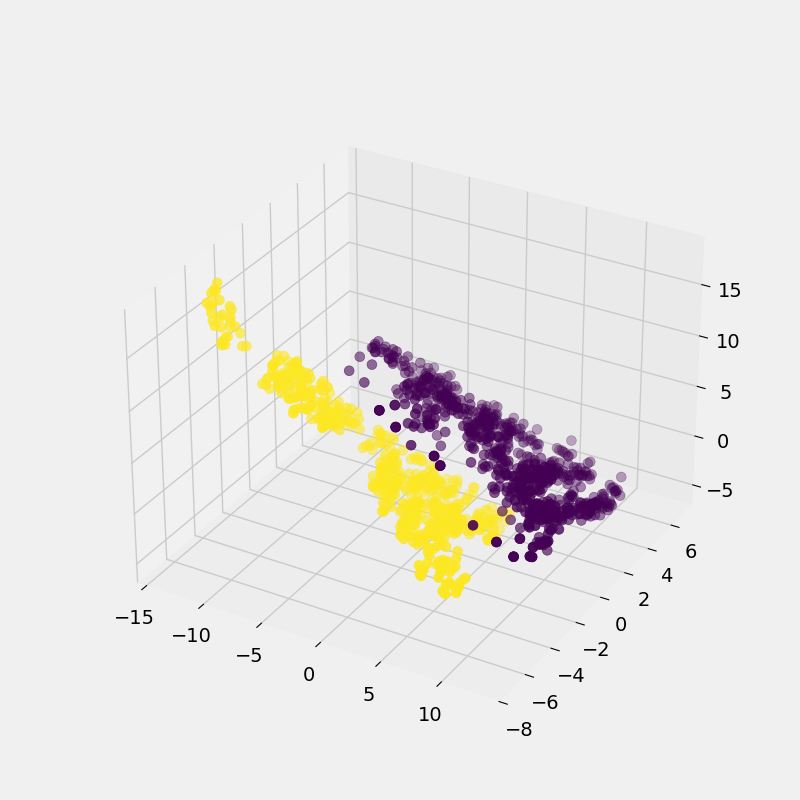

In [13]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

In [14]:
# don't worry about any of this right now

%matplotlib inline

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, point):
    """The distance between p (an array of numbers) and the numbers in row i of attribute_table."""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    return attributes.apply(distance_from_point)

def table_with_distances(training, point):
    """A copy of the training table with the distance from each row to array p."""
    return training.with_column('Distance', all_distances(training, point))

def closest(training, point, k):
    """A table containing the k closest rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, p, k):
    """Classify an example with attributes p using k-nearest neighbor classification with the given training table."""
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

def show_closest(point):
    """point = array([x,y]) 
    gives the coordinates of a new point
    shown in red"""
    
    HemoGl = ckd.select('Hemoglobin', 'Glucose')
    t = closest(HemoGl, point, 1)
    x_closest = t.row(0).item(0)
    y_closest = t.row(0).item(1)
    ckd.scatter('Hemoglobin', 'Glucose', group='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot(make_array(point.item(0), x_closest), make_array(point.item(1), y_closest), color='k', lw=2);


def plot_all_points(test_grid):
    test_grid.scatter('Hemoglobin', 'Glucose', color='red', alpha=0.4, s=30)

    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);
    
def classify_grid(training, test, k):
    c = make_array()
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = np.append(c, classify(training, make_array(test.row(i)), k))   
    return c

def plot_all_points_classified(test_grid):
    c = classify_grid(ckd.drop('White Blood Cell Count'), test_grid, 1)
    test_grid = test_grid.with_column('Class', c)
    test_grid.scatter('Hemoglobin', 'Glucose', group='Class', alpha=0.4, s=30)
    
    plt.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Class'), edgecolor='k')

    plt.xlim(-2, 2)
    plt.ylim(-2, 2);

In [15]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'White Blood Cell Count', standard_units(ckd.column('White Blood Cell Count')),
    'Class', ckd.column('Class')
)

# color_table = Table().with_columns(
#     'Class', make_array(0, 1),
#     'Color', make_array('darkblue', 'gold')
# )
# ckd = ckd.join('Class', color_table)
ckd

Hemoglobin,Glucose,White Blood Cell Count,Class
-0.865744,-0.221549,-0.569768,1
-1.45745,-0.947597,1.16268,1
-1.00497,3.84123,-1.27558,1
-2.81488,0.396364,0.809777,1
-2.08395,0.643529,0.232293,1
-1.35303,-0.561402,-0.505603,1
-0.413266,2.04928,0.360623,1
-1.28342,-0.947597,3.34429,1
-1.10939,1.87936,-0.409356,1
-1.35303,0.489051,1.96475,1


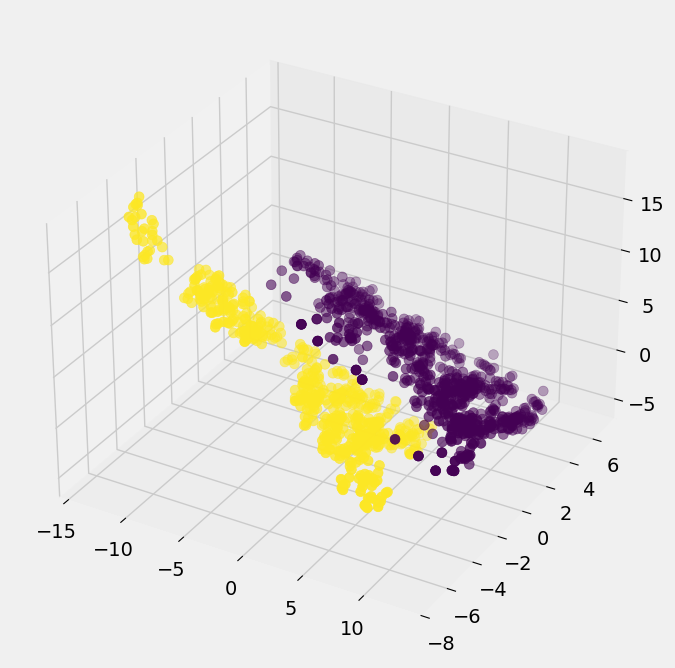

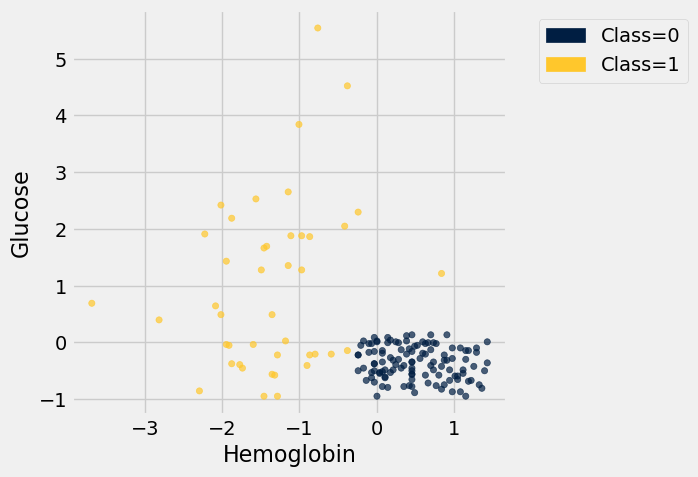

In [16]:
ckd.scatter('Hemoglobin', 'Glucose', group='Class')

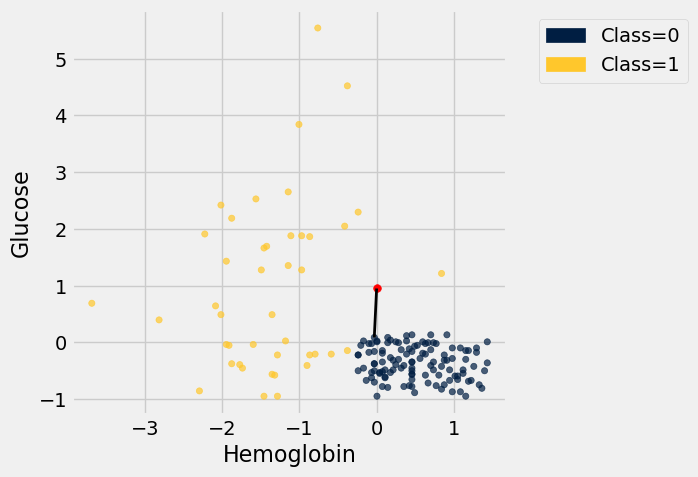

In [17]:
alice = make_array(0, 0.95)
show_closest(alice)

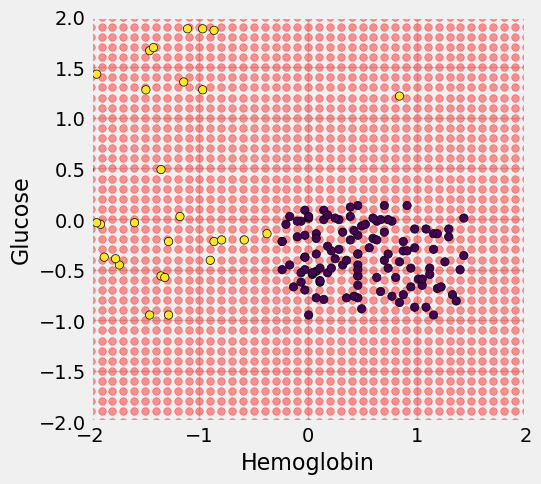

In [18]:
x_array = make_array()
y_array = make_array()
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

test_grid = Table().with_columns(
    'Hemoglobin', x_array,
    'Glucose', y_array
)

plot_all_points(test_grid)

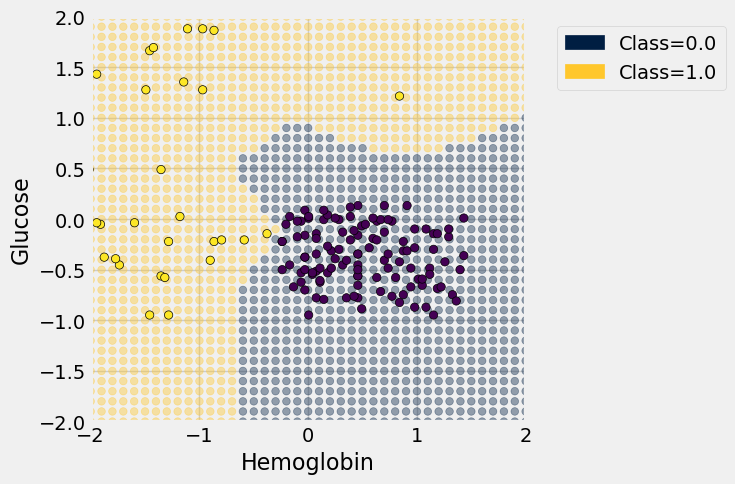

In [19]:
plot_all_points_classified(test_grid)

In [20]:
shuffled_ckd = ckd.sample(with_replacement=False)

training = shuffled_ckd.take(np.arange(79))
testing = shuffled_ckd.take(np.arange(79, 158))

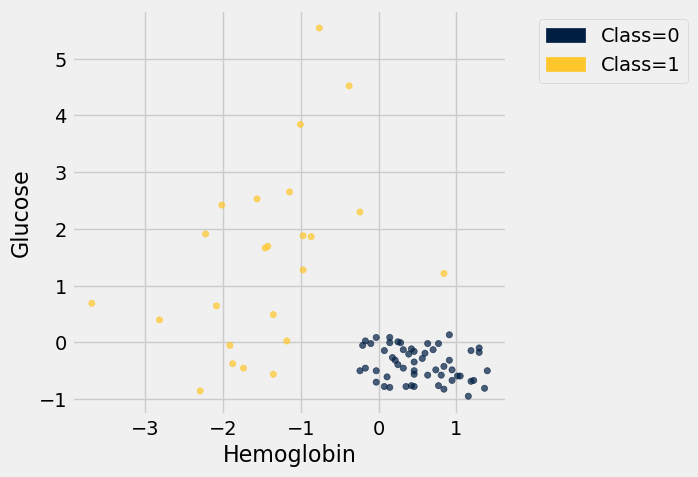

In [21]:
training.scatter('Hemoglobin', 'Glucose', group='Class')

---

In [22]:
ckd = Table.read_table('data/ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd = ckd.select('Hemoglobin', 'Glucose', 'Class')
ckd

Hemoglobin,Glucose,Class
11.2,117,1
9.5,70,1
10.8,380,1
5.6,157,1
7.7,173,1
9.8,95,1
12.5,264,1
10,70,1
10.5,253,1
9.8,163,1


In [23]:
alice = make_array(0,1.1)
alice

array([ 0. ,  1.1])

In [24]:
ckd.row(0)

Row(Hemoglobin=11.199999999999999, Glucose=117, Class=1)

In [25]:
type(ckd.row(0))

datascience.tables.Row

In [26]:
ckd.row(0).item(1)

117

In [27]:
np.array(ckd.row(0)) # make_array doesn't work for conversion

array([  11.2,  117. ,    1. ])

In [28]:
patient = ckd.drop('Class').row(0)
patient

Row(Hemoglobin=11.199999999999999, Glucose=117)

In [29]:
np.array(patient)

array([  11.2,  117. ])

In [30]:
(alice.item(0) - patient.item(0)) ** 2 + (alice.item(1) - patient.item(1)) ** 2

13558.250000000002

In [31]:
alice - np.array(patient)

array([ -11.2, -115.9])

In [32]:
(alice - np.array(patient)) ** 2

array([   125.44,  13432.81])

In [33]:
np.sum((alice - np.array(patient)) ** 2)

13558.250000000002

In [34]:
np.sum((alice - np.array(patient)) ** 2) ** 0.5

116.43989866021012

In [35]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sum((point1-point2)**2) ** 0.5

In [36]:
distance(alice, np.array(patient))

116.43989866021012

In [37]:
def distance_from_alice(row):
    return distance(alice, np.array(row))

In [38]:
distance_from_alice(ckd.drop('Class').row(0))

116.43989866021012

In [39]:
distances = ckd.drop('Class').apply(distance_from_alice)
distances

array([ 116.43989866,   69.55185116,  379.05388799,  156.00054487,
        172.0723685 ,   94.41001006,  263.19699846,   69.62190747,
        252.11874187,  162.19633165,  128.22332081,  132.3015495 ,
         75.23576277,  279.20281159,  209.5194979 ,  218.14804606,
        294.0439593 ,  117.4545444 ,  223.04712507,  127.16465704,
        117.514297  ,  104.49124365,  287.00874551,  272.02665311,
        121.55480246,  302.07907905,  101.27437978,  106.22476171,
        116.33060646,  238.08960498,   93.42601351,  128.15623278,
        251.14985566,  254.00492121,  252.13571742,  213.1788451 ,
        489.0352339 ,  162.09262784,  240.0920032 ,  213.10741423,
        105.25193585,  423.08766231,  174.92747068,  139.70758748,
         70.96625959,   82.44768038,  118.90151387,   98.75935399,
        120.66884436,  130.70677106,   90.98356995,   97.89187913,
        104.15190829,  130.66300165,  122.08935253,  117.92311054,
        117.02670635,  131.6896731 ,   96.9456033 ,  132.55885

In [40]:
def all_distances(training, new_row):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_new_row(row):
        return distance(np.array(new_row), np.array(row))
    return attributes.apply(distance_from_new_row)

In [41]:
distances = all_distances(ckd.drop('Class'), alice)

In [42]:
ckd_with_distances = ckd.with_column('Distance from Alice', distances)
ckd_with_distances 

Hemoglobin,Glucose,Class,Distance from Alice
11.2,117,1,116.44
9.5,70,1,69.5519
10.8,380,1,379.054
5.6,157,1,156.001
7.7,173,1,172.072
9.8,95,1,94.41
12.5,264,1,263.197
10,70,1,69.6219
10.5,253,1,252.119
9.8,163,1,162.196


In [43]:
ckd_with_distances.sort('Distance from Alice')

Hemoglobin,Glucose,Class,Distance from Alice
9.5,70,1,69.5519
10,70,1,69.6219
13.7,70,0,70.2488
17,70,0,70.9663
15.1,74,0,74.4474
7.1,76,1,75.2358
16.5,75,0,75.7196
16.8,75,0,75.7856
16.1,78,0,78.5673
17.6,79,0,79.8634


In [44]:
ckd_with_distances.sort('Distance from Alice').take(np.arange(5))

Hemoglobin,Glucose,Class,Distance from Alice
9.5,70,1,69.5519
10,70,1,69.6219
13.7,70,0,70.2488
17,70,0,70.9663
15.1,74,0,74.4474


In [45]:
def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def nearest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    nearest_neighbors_table = sorted_by_distance.take(np.arange(k))
    return nearest_neighbors_table

five_nearest_neighbors = nearest(ckd, alice, 5)
five_nearest_neighbors

Hemoglobin,Glucose,Class,Distance
9.5,70,1,69.5519
10,70,1,69.6219
13.7,70,0,70.2488
17,70,0,70.9663
15.1,74,0,74.4474


In [46]:
ones = five_nearest_neighbors.where('Class', are.equal_to(1)).num_rows
zeros = five_nearest_neighbors.where('Class', are.equal_to(0)).num_rows

if ones > zeros:
    print(1)
else:
    print(0)

0


In [47]:
def majority(nearest_neighbors_table):
    """1 if the majority of the class_name column is 1s, and 0 otherwise."""
    ones = nearest_neighbors_table.where('Class', are.equal_to(1)).num_rows
    zeros = nearest_neighbors_table.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

In [48]:
majority(five_nearest_neighbors)

0

In [49]:
def knn(training, new_point, k):
    nearest_neighbors_table = nearest(training, new_point, k)
    return majority(nearest_neighbors_table)

In [50]:
knn(ckd, alice, 5)

0

In [51]:
# distance works no matter the dimensions!

In [52]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [53]:
wine = Table.read_table('data/wine.csv')
wine.sample(5)

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
3,12.45,3.03,2.64,27,97,1.9,0.58,0.63,1.14,7.5,0.67,1.73,880
1,12.85,1.6,2.52,17.8,95,2.48,2.37,0.26,1.46,3.93,1.09,3.63,1015
2,11.61,1.35,2.7,20,94,2.74,2.92,0.29,2.49,2.65,0.96,3.26,680
2,11.76,2.68,2.92,20,103,1.75,2.03,0.6,1.05,3.8,1.23,2.5,607


In [54]:
# we'll focus on class 1 vs. the rest
def is_one(x):
    if x == 1:
        return 1
    else:
        return 0
    
wine = wine.with_column('Class', wine.apply(is_one, 0))
wine

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.2,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050
1,13.16,2.36,2.67,18.6,101,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.5,16.8,113,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480
1,13.24,2.59,2.87,21,118,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735
1,14.2,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
1,14.39,1.87,2.45,14.6,96,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290
1,14.06,2.15,2.61,17.6,121,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295
1,14.83,1.64,2.17,14,97,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045
1,13.86,1.35,2.27,16,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [55]:
wine_attributes = wine.drop('Class')
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(1)))

31.265012394048398

In [56]:
wine.row(177)

Row(Class=0, Alcohol=14.130000000000001, Malic Acid=4.0999999999999996, Ash=2.7400000000000002, Alcalinity of Ash=24.5, Magnesium=96, Total Phenols=2.0499999999999998, Flavanoids=0.76000000000000001, Nonflavanoid phenols=0.56000000000000005, Proanthocyanins=1.3500000000000001, Color Intensity=9.1999999999999993, Hue=0.60999999999999999, OD280/OD315 of diulted wines=1.6000000000000001, Proline=560)

In [57]:
distance(np.array(wine_attributes.row(0)), np.array(wine_attributes.row(177)))

506.05936766351834

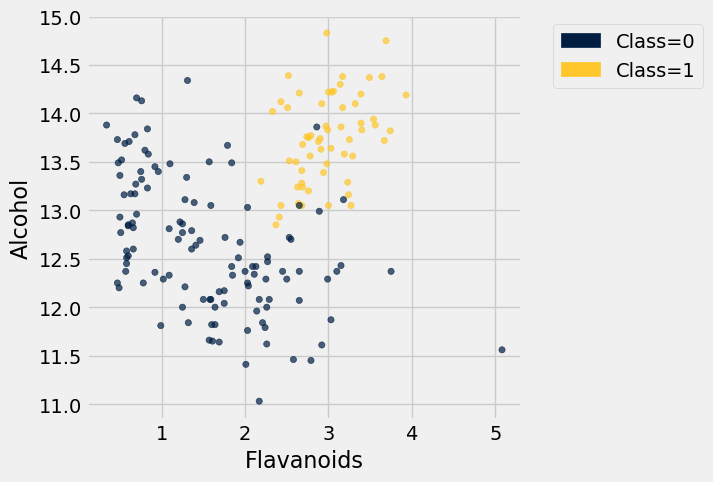

In [58]:
wine.scatter('Flavanoids', 'Alcohol', group='Class')

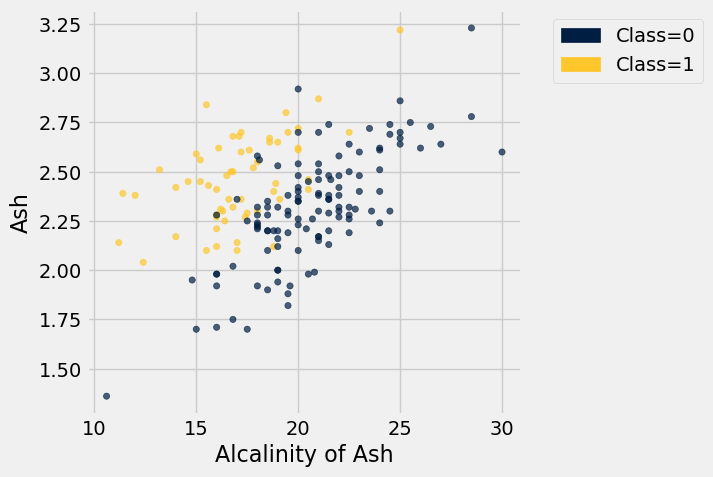

In [59]:
wine.scatter('Alcalinity of Ash', 'Ash', group='Class')

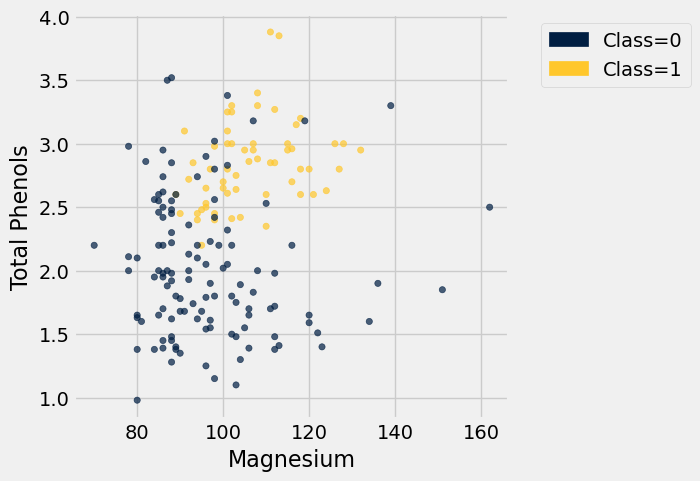

In [60]:
wine.scatter('Magnesium', 'Total Phenols', group='Class')

In [61]:
wine.row(0)

Row(Class=1, Alcohol=14.23, Malic Acid=1.71, Ash=2.4300000000000002, Alcalinity of Ash=15.6, Magnesium=127, Total Phenols=2.7999999999999998, Flavanoids=3.0600000000000001, Nonflavanoid phenols=0.28000000000000003, Proanthocyanins=2.29, Color Intensity=5.6399999999999997, Hue=1.04, OD280/OD315 of diulted wines=3.9199999999999999, Proline=1065)

In [62]:
nearest(wine, wine_attributes.row(0), 5)

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline,Distance
1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065,0
1,13.74,1.67,2.25,16.4,118,2.6,2.9,0.21,1.62,5.85,0.92,3.2,1060,10.3928
1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.3,1.25,5.24,0.87,3.33,1080,22.3407
1,14.1,2.02,2.4,18.8,103,2.75,2.92,0.32,2.38,6.2,1.07,2.75,1060,24.7602
1,14.38,3.59,2.28,16,102,3.25,3.17,0.27,2.19,4.9,1.04,3.44,1065,25.0947


In [63]:
wine.row(177)

Row(Class=0, Alcohol=14.130000000000001, Malic Acid=4.0999999999999996, Ash=2.7400000000000002, Alcalinity of Ash=24.5, Magnesium=96, Total Phenols=2.0499999999999998, Flavanoids=0.76000000000000001, Nonflavanoid phenols=0.56000000000000005, Proanthocyanins=1.3500000000000001, Color Intensity=9.1999999999999993, Hue=0.60999999999999999, OD280/OD315 of diulted wines=1.6000000000000001, Proline=560)

In [64]:
nearest(wine, wine_attributes.row(177), 5)

Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of diulted wines,Proline,Distance
0,14.13,4.1,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.6,560,0
0,12.81,2.31,2.4,24,98,1.15,1.09,0.27,0.83,5.7,0.66,1.36,560,4.78493
0,11.65,1.67,2.62,26,88,1.92,1.61,0.4,1.34,2.6,1.36,3.21,562,11.393
0,13.62,4.95,2.35,20,92,2,0.8,0.47,1.02,4.4,0.91,2.05,550,12.6822
0,12.6,1.34,1.9,18.5,88,1.45,1.36,0.29,1.35,2.45,1.04,2.77,562,12.7504


---

In [65]:
shuffled_wine = wine.sample(with_replacement=False) 
training_set = shuffled_wine.take(np.arange(89))
test_set  = shuffled_wine.take(np.arange(89, 178))

In [66]:
make_array(1, 2, 3) == make_array(3, 2, 3)

array([False,  True,  True], dtype=bool)

In [67]:
np.count_nonzero(make_array(1, 2, 3) == make_array(3, 2, 3))

2

In [68]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    
    def classify_testrow(row):
        return classify(training, row, k)
    
    c = test_attributes.apply(classify_testrow)
    return np.count_nonzero(c == test.column('Class')) / test.num_rows

In [69]:
evaluate_accuracy(training_set, test_set, 5)

0.8876404494382022

In [70]:
patients = Table.read_table('data/breast-cancer.csv').drop('ID')
patients.sample(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,5,1,3,1,1,0
4,1,1,1,2,1,3,2,1,0
5,7,10,6,5,10,7,5,1,1
1,1,1,1,2,1,3,1,1,0
6,1,1,1,2,1,2,1,1,0


In [71]:
patients.num_columns

10

In [72]:
patients.group('Class')

Class,count
0,444
1,239


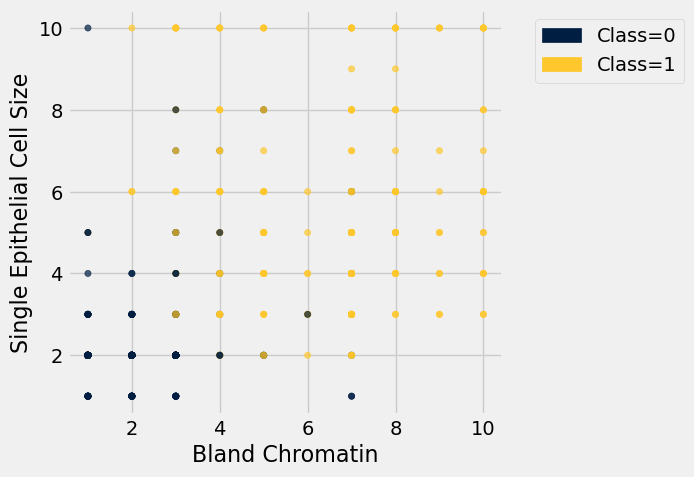

In [73]:
# overplotting!
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

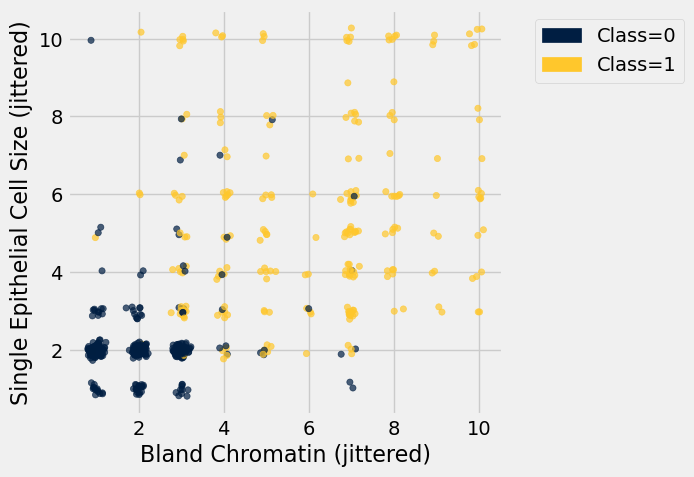

In [74]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, group='Class')

In [75]:
shuffled_patients = patients.sample(683, with_replacement=False) 
training_set = shuffled_patients.take(np.arange(342))
test_set  = shuffled_patients.take(np.arange(342, 683))

In [76]:
evaluate_accuracy(training_set, test_set, 5)

0.9736070381231672

---

In [77]:
all_sales = Table.read_table('data/house.csv')
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')
sales.sort('SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
35000,498,0,498,216,0,0,8088,1922,2006
39300,334,0,0,0,0,0,5000,1946,2007
40000,649,668,649,250,0,54,8500,1920,2008
45000,612,0,0,308,0,0,5925,1940,2009
52000,729,0,270,0,0,0,4130,1935,2008
52500,693,0,693,0,0,20,4118,1941,2006
55000,723,363,723,400,0,24,11340,1920,2008
55000,796,0,796,0,0,0,3636,1922,2008
57625,810,0,0,280,119,24,21780,1910,2009
58500,864,0,864,200,0,0,8212,1914,2010


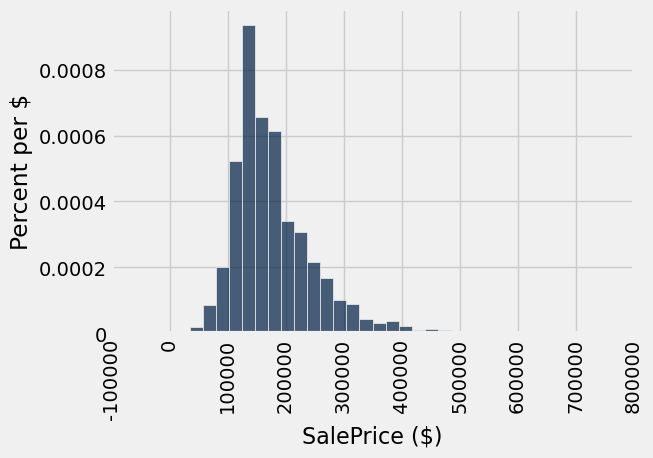

In [78]:
sales.hist('SalePrice', bins=32, unit='$')

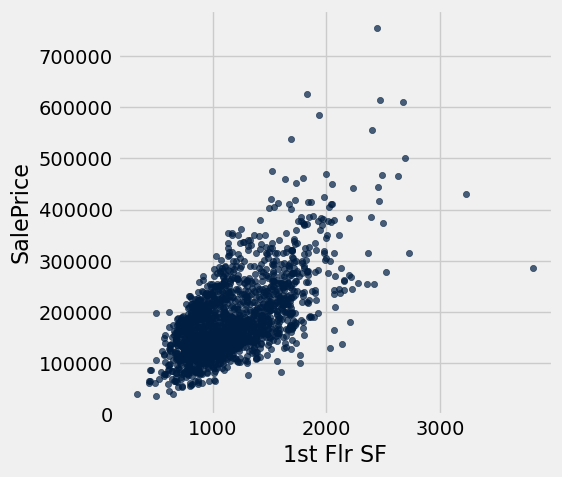

In [79]:
sales.scatter('1st Flr SF', 'SalePrice')

In [80]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

correlation(sales, 'SalePrice', '1st Flr SF')

0.64246625410302249

In [81]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.642466254103
Correlation of 2nd Flr SF and SalePrice:	 0.35752189428
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757
Correlation of Garage Area and SalePrice:	 0.638594485252
Correlation of Wood Deck SF and SalePrice:	 0.352698666195
Correlation of Open Porch SF and SalePrice:	 0.336909417026
Correlation of Lot Area and SalePrice:	 0.290823455116
Correlation of Year Built and SalePrice:	 0.565164753714
Correlation of Yr Sold and SalePrice:	 0.0259485790807


In [82]:
both_floors = sales.column(1) + sales.column(2)
correlation(sales.with_column('Both Floors', both_floors), 'SalePrice', 'Both Floors')

0.7821920556134877

In [83]:
train, test = sales.split(sales.num_rows // 2)
print(train.num_rows, 'training and', test.num_rows, 'test instances.')

1001 training and 1001 test instances.


In [84]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

example_row = test.drop('SalePrice').row(0)
print('Predicting sale price for:', example_row)
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))
print('Actual sale price:', test.column('SalePrice').item(0))
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Predicting sale price for: Row(1st Flr SF=984, 2nd Flr SF=0, Total Bsmt SF=984.0, Garage Area=308.0, Wood Deck SF=0, Open Porch SF=0, Lot Area=9750, Year Built=1959, Yr Sold=2008)
Using slopes: [ 10.28853937   8.49270043  10.51622452   9.72525446   9.88279831
  10.81449386   9.1464708   10.84814346   8.59187875]
Result: 151149.361914
Actual sale price: 110000
Predicted sale price using random slopes: 151149.361914


In [85]:
train_prices = train.column(0)
train_attributes = train.drop(0)

def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 78693.8055274


In [86]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
print('The best slopes for the training set:')
Table(train_attributes.labels).with_row(list(best_slopes)).show()
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

The best slopes for the training set:


1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
77.6359,77.2756,48.5955,50.2589,25.1911,16.3883,0.447198,546.669,-544.823


RMSE of all training examples using the best slopes: 29598.4147677


In [87]:
test_prices = test.column(0)
test_attributes = test.drop(0)

def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 32501.5766729


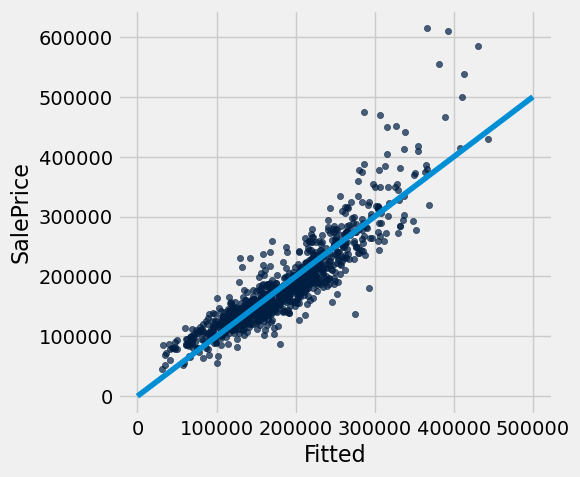

In [88]:
def fit(row):
    return sum(best_slopes * np.array(row))

test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plt.plot([0, 5e5], [0, 5e5]);

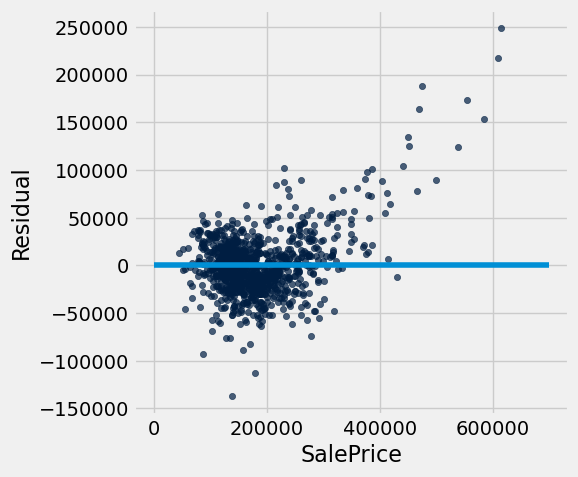

In [89]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plt.plot([0, 7e5], [0, 0]);

In [90]:
# nearest neighbors works too!

In [91]:
train_nn = train.select(0, 1, 2, 3, 4, 8) # taking just a few highly-correlated attributes to speed things up
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
217000,1546,0,1546,796,2005
109000,735,299,735,240,1940
98300,1048,0,0,420,1950


In [92]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))

example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, 5, 'SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
145000,992,0,992,294,1967,19.6977
133500,1005,0,1005,319,1956,31.8119
144900,960,0,960,300,1963,35.0999
151500,958,0,958,301,1960,37.4433
122000,960,0,960,330,1955,40.6448


In [93]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

predict_nn(example_nn_row)

139380.0

In [94]:
print('Actual sale price:', test_nn.column('SalePrice').item(0))
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 110000
Predicted sale price using nearest neighbors: 139380.0


In [95]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  32501.5766729
Test set RMSE for nearest neighbor regression: 34762.8270203


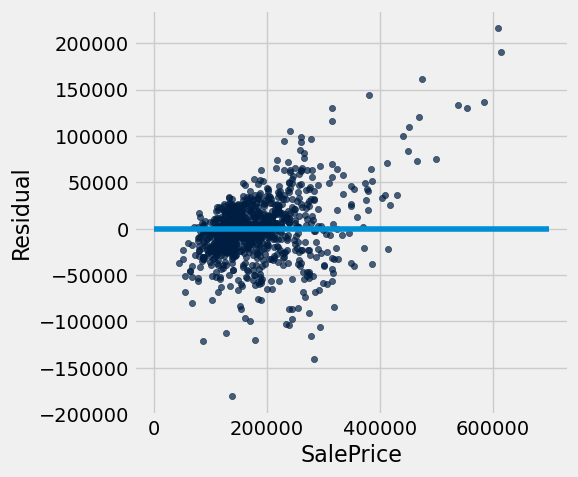

In [96]:
test.with_column('Residual', test_prices-nn_test_predictions).scatter(0, 'Residual')
plt.plot([0, 7e5], [0, 0]);